6.1.5 AdaGrad
    - 학습률이 너무 작으면, 학습 시간이 오래 소요
    - 학습률이 너무 크면, 발산하여 올바른 학습 불가능
    
    - 학습률 감소(learning rate decay): 학습을 진행하면서 학습률을 점차 줄여가는 방법

    - AdaGrad: '각각의' 매개변수에 적응적으로 학습률을 조정하며 학습 진행
    
    - W: 갱신할 가중치 매개변수
    - aL/aW: W에 대한 손실 함수의 기울기
    - n: 학습률
    - (*): 행렬의 원소별 곱셈
    - 1 * h^(-1/2) == 매개변수의 원소 중에서 많이 움직인(크게 갱신된) 원소의 학습률은 낮아짐 

    
    - h <- h + aL/aW (*) aL/aW
    - W <- W + n * 1/h^(1/2) (*) aL/aW

    - 과거의 기울기를 제곱하여 계속 더해감 == 학습을 진행할수록 갱신강도가 약해짐
    -> 어느 순간 갱신량이 0이 되어 갱신되지 않는 문제점 발생

    - RMSProp: 과거의 모든 기울기를 균일하게 더하지 않고, 먼 과거의 기울기는 서서히 잊고 새로운 기울기 정보를 크게 반영
    == 자수이동평균(expotential moving average, EMA), 과거 기울기의 반영 규모를 기하급수적으로 감소시킴

In [3]:
import numpy as np

class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None

    def update(self, params, grads):
        if self.h is None:
            self.h = {}
        
        for key, val in params.items():
            self.h[key] = np.zeros_like(val)
        
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -+ self.lr *grads[key] / (np.sqrt(self.h[key]) + 1e-7)
            # 1e-7: self.h[key]에 0이 있더라도 0으로 나누는 케이스 방지


6.1.6 Adam
    - 모멘텀과 AdaGrad 기법 융합에서 시작
    - 하이퍼파라미터의 '편향 보정'이 진행됨
    - 하이퍼파라미터
        - alpha: 지금까지의 학습률
        - beta1: 일차 모멘텀용 계수(기본 설정값: 0.9)
        - beta2: 이차 모멘텀용 계수(기본 설정값: 0.999)

6.1.7 갱신방법 선택
    - 풀어야 할 문제가 무엇인지
    - 하이퍼파라미터를 어떻게 설정하는지

    - 많은 연구에서 SGD를 사용하거나
    - 최근 Adam도 많이 사용

6.2 가중치의 초깃값
    - 가중치의 초깃값을 무엇으로 설정하느냐가 신경망 학습의 성패를 가르기도 함

6.2.1 초깃값이 0이라면?
    - 가중치 감소(weight decay): 오버피팅을 억제해 범용 성능을 높이는 기술, 가중치 매개변수의 값이 작아지도록 학습하는 방법
    
    - 0이라면 or 균일한 값으로 설정한다면: 오차역전파법에서 모든 가중치의 값이 똑같이 갱신되기 때문 == 많은 수의 가중치 매개변수의 의미가 없어짐
    -> 가중치의 대칭적인 구조 방지를 위해, 초깃값을 무작위로 설정해야 함

6.2.2 은닉층의 활성화값 분포
    - 은닉층의 활성화값: 활성화 함수의 출력 데이터
    
    - 가중치의 초깃값에 따른 은닉층 활성화값들의 변화 관측
    - 시그모이드 함수를 사용하는 5층 신경망에 무작위로 생성한 입력 데이터를 전달해, 각 층의 활성화값 분포를 히스토그램으로 시각화

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):                 # 활성화 함수
    return 1/(1+np.exp(-x))

x = np.random.randn(1000, 100)  # 1000개의 데이터, 정규분포로 무작위 생성
node_num = 100                  # 각 은닉층의 노드(뉴런) 스
hidden_layer_size = 5           # 5개의 은닉층
activations = {}                # 활성화 결과(활성화값) 저장할 변수

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    w = np.random.randn(node_num, node_num) * 1 # 표준편차가 1인 정규분포를 이용
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z

<function matplotlib.pyplot.show(close=None, block=None)>

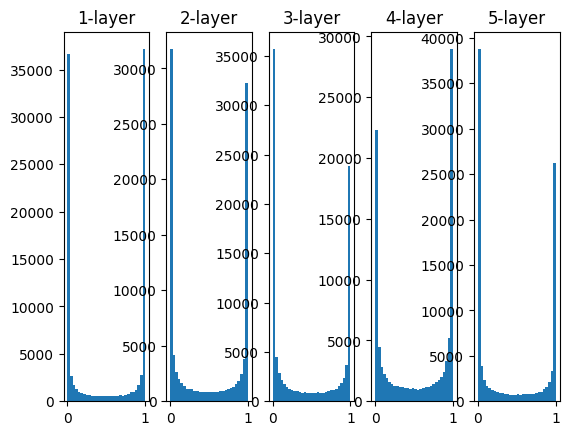

In [6]:
# histogram
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show

- 각 층의 활성화값들이 0과 1에 치우져 분포
- 출력이 0 또는 1에 가까워지자 미분이 0으로 다가감
== 데이터가 0과 1에 치우쳐 분포하다면, 역전파의 기울기 값이 점점 작아지다가 사라짐
== 기울기 소실(gradient vanishing)

<function matplotlib.pyplot.show(close=None, block=None)>

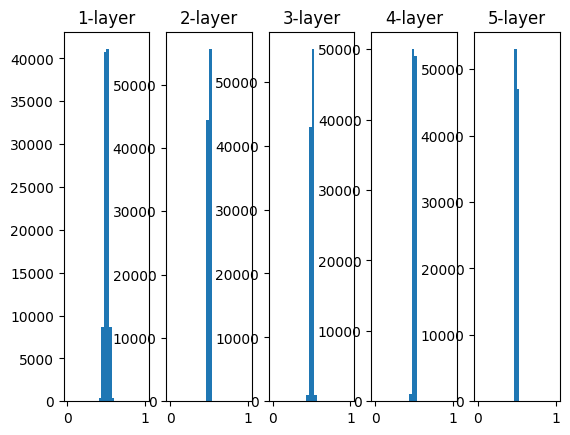

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):                 # 활성화 함수
    return 1/(1+np.exp(-x))

x = np.random.randn(1000, 100)  # 1000개의 데이터, 정규분포로 무작위 생성
node_num = 100                  # 각 은닉층의 노드(뉴런) 스
hidden_layer_size = 5           # 5개의 은닉층
activations = {}                # 활성화 결과(활성화값) 저장할 변수

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # w = np.random.randn(node_num, node_num) * 1 # 표준편차가 1인 정규분포를 이용
    w = np.random.randn(node_num, node_num) * 0.01 # 표준편차가 1인 정규분포를 이용
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z

# histogram
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show

- 표준편차를 0.01로 한 정규분포의 경우
- 0.5 부근에 집중, '치우침'의 문제 여전히 발생
== 다수의 뉴런이 거의 같은 값을 출력하고 있음 == 다수의 뉴런 존재 의미 없어짐
== "표현력을 제한한다"

- Xavier 초깃값: cafe 프레임워크에서 인수를 xavier로 지정 가능
- 각 층의 활성화값들을 광범위하게 분포시킬 목적으로 가중치의 적절한 분포를 찾고자 함
- 앞 계층의 노드가 n개일 때, 표준편차가 n^(-1/2)인 분포 사용

<function matplotlib.pyplot.show(close=None, block=None)>

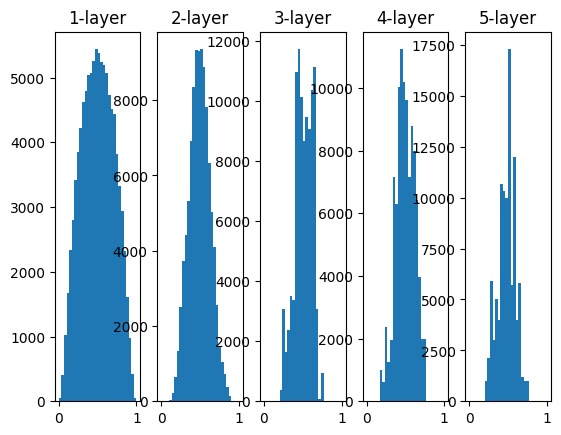

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):                 # 활성화 함수
    return 1/(1+np.exp(-x))

x = np.random.randn(1000, 100)  # 1000개의 데이터, 정규분포로 무작위 생성
node_num = 100                  # 각 은닉층의 노드(뉴런) 스
hidden_layer_size = 5           # 5개의 은닉층
activations = {}                # 활성화 결과(활성화값) 저장할 변수

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # w = np.random.randn(node_num, node_num) * 1 # 표준편차가 1인 정규분포를 이용
    # w = np.random.randn(node_num, node_num) * 0.01 # 표준편차가 1인 정규분포를 이용
    w = np.random.randn(node_num, node_num) / np.sqrt(node_num) # 표준편차가 1인 정규분포를 이용
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z

# histogram
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show

- 층이 깊어지면서, 형태가 일그러지긴 하지만
(sigmoid 함수 대신 tanh 함수를 이용하면 개선됨)
- 앞의 방식보다 비교적 넓게 분포됨

- sigmoid: S자 모양 곡선 함수, (x, y) = (0, 0.5)에서 대칭
- tanh: S자 모양 곡선 함수, (x, y) = (0, 0)에서 대칭
- 활성화 함수용으로는 원점에서 대칭인 함수가 바람직함